Import the Relevant Packages

In [31]:
import io
import itertools

import numpy as np
import sklearn.metrics
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
sns.set()

# Downloading and preprocessing the MNIST dataset

In [2]:
# Before begining with the model and training, the dataset first needs to be preprocessed
# This is a very important step in all of machine learning

# The MNIST dataset is, in general, highly processed already - after all its 28x28 grayscale images of clearly visible digits
# Thus, the preprocessing will be limited to scaling the pixel values, shuffling the data and creating a validation set

# NOTE: When finally deploying a model in practice, it might be a good idea to include the prerpocessing as initial layers
# In that way, the users could just plug the data (images) directly, instead of being required to resize/rescale it before

### Defining some constants/hyperparameters

In [3]:
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

## Downloading the MNIST dataset

In [4]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

# When 'with_info' is set to True, tfds.load() returns two variables: 
# - the dataset (including the train and test sets) 
# - meta info regarding the dataset itself

### Extracting the train and test datasets

In [5]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

### Rescaling the images

Since each image is a gray-scale image with each pixel ranging from 0 to 255, it would be nice to rescale all of them to values ranging from 0 to 1 by simply dividing them by 255

In [6]:
def rescale_images(image, label):
    image = tf.cast(image, tf.float32) # Make sure all rescaled images will be of type float32
    image /= 255.0 # Achieve the scaling by dividing each image by 255.0
    return image, label

#### Scaling the Train and Test datasets

In [7]:
scaled_trained_and_validation_data = mnist_train.map(rescale_images) # Maps the old data to new scale
scaled_test_data = mnist_test.map(rescale_images) # Maps the old data to new scale

## Shuffling the Dataset

In [8]:
scaled_trained_and_validation_data = scaled_trained_and_validation_data.shuffle(BUFFER_SIZE)
scaled_test_data = scaled_test_data.shuffle(BUFFER_SIZE)

## Training and Validation Splitting
Splitting the now Shuffled scaled_trained_and_validation_data into training and validation datasets

In [9]:
# I am using train_test_split() from sklearn to split my dataset

# from sklearn.model_selection import train_test_split

In [10]:
# scaled_trained_data, scaled_validation_data = train_test_split(scaled_trained_and_validation_data,
#                                                               test_size=0.1,
#                                                               random_state=42)

Using train_test_split's  **test_size=0.1** does not return an integer value as size of the scaled_validation_data above so I will have to do the splitting manually

In [11]:
# Defining the size of the validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [12]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [13]:
# Splitting the dataset into training + validation
train_data = scaled_trained_and_validation_data.skip(num_validation_samples)
validation_data = scaled_trained_and_validation_data.take(num_validation_samples)

## Batching the datasets

For proper functioning of the model, the batch size for the validation and test sets needs to be one big size that can take all the specific datasets into one batch


In [14]:
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
scaled_test_data = scaled_test_data.batch(num_test_samples)

In [15]:
# Extracting the numpy arrays from the validation data for the calculation of the Confusion Matrix
for images, labels in validation_data:
    images_val = images.numpy()
    labels_val = labels.numpy()

# Creating and Training the Model

Outline of the model/architecture of the CNN to be implemented

CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation="relu", input_shape=(28,28,1)), # 50 kernels of size 5X5
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), # input_shape is needed only when the layer is the first one
    # (2,2) is the default pool size so it could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # Number of desired output layer
])

# NB* The activation function was not included in the last layer as it is impossible to provide 
# Numerically stable loss calculations for all Models
# The softmax can be incorporated into the loss function itself

### Model summary and parameters

In [17]:
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
Layer (type)                     Output Shape                  Param #     
conv2d (Conv2D)                  (None, 24, 24, 50)            1300        
___________________________________________________________________________
max_pooling2d (MaxPooling2D)     (None, 12, 12, 50)            0           
___________________________________________________________________________
conv2d_1 (Conv2D)                (None, 10, 10, 50)            22550       
___________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 5, 5, 50)              0           
___________________________________________________________________________
flatten (Flatten)                (None, 1250)                  0           
___________________________________________________________________________
dense (Dense)                    (None, 10)                    12510

### Defining the loss function

In [18]:
# In general, the model needs to output the probabilities for each class, 
# this can be achieved with a softmax activation in the last dense layer

# However, when using the softmax activation, the loss can rarely be unstable

# Thus, instead of incorporating the softmax into the model itself,
# the loss calculation can be use which automatically corrects for the missing softmax

# That is the reason for 'from_logits=True'

In [19]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Compiling the model

In [20]:
model.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

In [21]:
log_dir = "Logs\\fit\\" + "run-1"

### Plot of confusion Matrix

In [22]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

### Convert Confusion Matrix Plot to an Image

In [23]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [24]:
# Define a file writer variable for logging purposes
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

In [25]:
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(images_val)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
    
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [26]:
# Defining the callbacks
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', # monitor the validation loss function
    mode = 'auto',    
    min_delta = 0,
    patience = 2, # Stop when val_loss starts increasing after two epochs
    verbose = 0, 
    restore_best_weights = True
)

#### Log only Tensor Board 

In [28]:
# Logging the training process data to use later in tensorboard
# log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Training the model

In [32]:
model.fit(
    train_data,
    epochs = NUM_EPOCHS, 
    callbacks = [tensorboard_callback, cm_callback, early_stopping], # early_stopping should always be the last clbc
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
422/422 - 125s - loss: 0.0717 - accuracy: 0.9786 - val_loss: 0.0540 - val_accuracy: 0.9810
Epoch 2/20
422/422 - 120s - loss: 0.0547 - accuracy: 0.9834 - val_loss: 0.0401 - val_accuracy: 0.9875
Epoch 3/20
422/422 - 135s - loss: 0.0450 - accuracy: 0.9864 - val_loss: 0.0428 - val_accuracy: 0.9870
Epoch 4/20
422/422 - 131s - loss: 0.0383 - accuracy: 0.9884 - val_loss: 0.0285 - val_accuracy: 0.9915
Epoch 5/20
422/422 - 129s - loss: 0.0329 - accuracy: 0.9896 - val_loss: 0.0218 - val_accuracy: 0.9932
Epoch 6/20
422/422 - 129s - loss: 0.0284 - accuracy: 0.9912 - val_loss: 0.0266 - val_accuracy: 0.9913
Epoch 7/20
422/422 - 123s - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0202 - val_accuracy: 0.9938
Epoch 8/20
422/422 - 124s - loss: 0.0230 - accuracy: 0.9927 - val_loss: 0.0188 - val_accuracy: 0.9933
Epoch 9/20
422/422 - 126s - loss: 0.0206 - accuracy: 0.9934 - val_loss: 0.0137 - val_accuracy: 0.9965
Epoch 10/20
422/422 - 131s - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.0156 - 

# Testing the model

In [33]:
test_loss, test_accuracy = model.evaluate(scaled_test_data)

1/1 [==============================] - 9s 9s/step - loss: 0.0335 - accuracy: 0.9893


In [34]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0335. Test accuracy: 98.93%


## Plotting images and the results

In [35]:
import matplotlib.pyplot as plt
import numpy as np

In [36]:
# Split the scaled_test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in scaled_test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

### The image to be displayed and tested

**i = 502**  Change this value to get predictions of different images

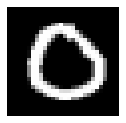

Label: 0


In [37]:
# i = 502 # Change this value to get predictions of different images

i = 34

# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

<BarContainer object of 10 artists>

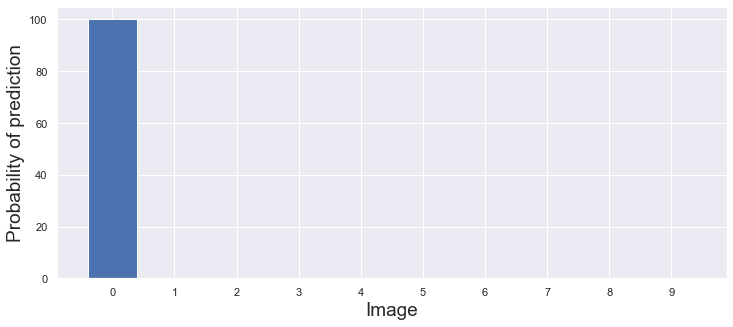

In [38]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.xlabel("Image", size=19)
plt.ylabel("Probability of prediction", size=19)
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])

#  Visualizing in Tensorboard

### Loading the Tensorboard extension

In [39]:
%load_ext tensorboard
%tensorboard --logdir "logs/fit"

Reusing TensorBoard on port 6006 (pid 1608), started 23:48:31 ago. (Use '!kill 1608' to kill it.)

To rerun tensorboard after the first run if there are any problems, open cmd and use the following commands

.../>taskkill /im tensorboard.exe /f

.../>del /q %TMP%\.tensorboard-info\*